# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in the `taxi.csv` file. The number of orders is in the '*num_orders*' column.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Data preparation

In [3]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
print(data.shape)
data.head()

(26496, 1)


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<Axes: xlabel='datetime'>

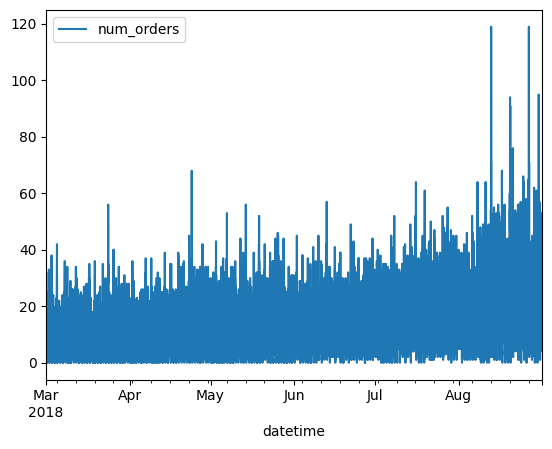

In [4]:
data.plot()

In [5]:
data = data.resample('1H').sum()

C:\Users\Andres Agudelo\AppData\Local\Temp\ipykernel_32464\2814516379.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


<Axes: xlabel='datetime'>

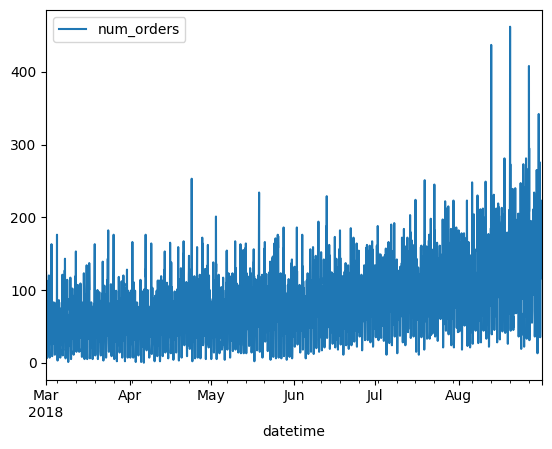

In [6]:
data.plot()

In [7]:
print(data.shape)

(4416, 1)


# 2. Analysis

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

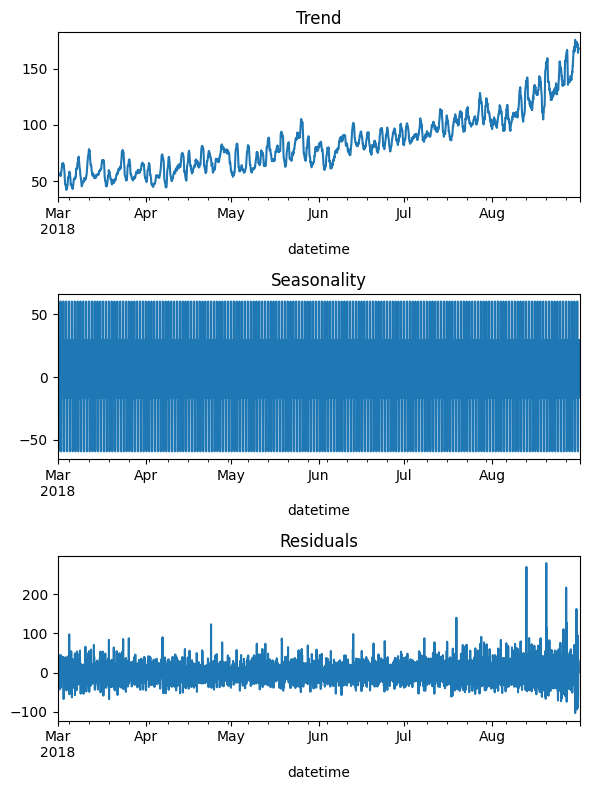

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

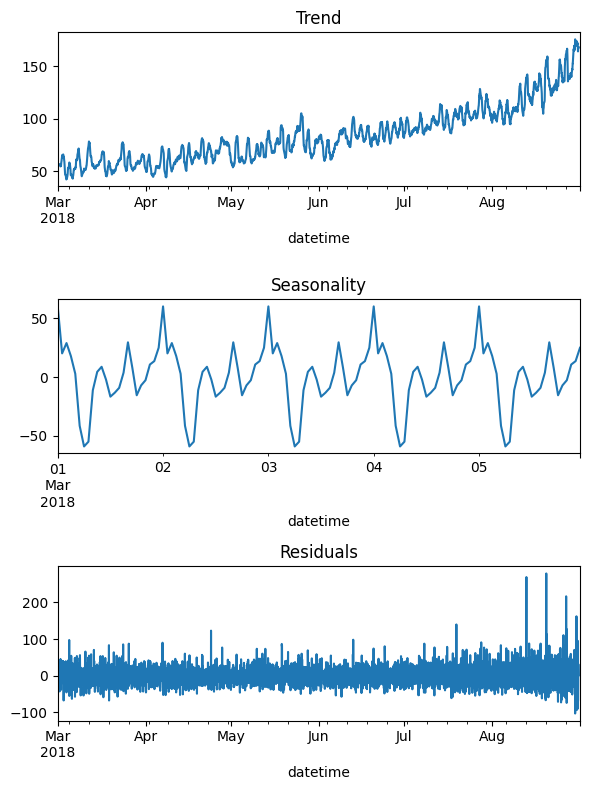

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['1 March 2018':'5 March 2018'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Findings:** There is an obvious six-month trend of increasing number of orders. Also one-day seasonality can be observed: at around 6 a.m. the number of orders is minimal due to small number of flights in the morning. The maximum is observed around midnight (a lot of arriving flights, other modes of transportation are unavailable).

# 3. Training

In [13]:
def make_features(data, max_lag=4, rolling_mean_size=10):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek_num'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data)
data = data.dropna()
print(data.shape)
data.head()

(4406, 10)


,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,40.1


In [15]:
from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(train.shape)
print(valid.index.min(), valid.index.max())
print(valid.shape)
print(test.index.min(), test.index.max())
print(test.shape)

2018-03-01 10:00:00 2018-07-28 01:00:00
(3568, 10)
2018-07-28 02:00:00 2018-08-13 14:00:00
(397, 10)
2018-08-13 15:00:00 2018-08-31 23:00:00
(441, 10)


In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
from sklearn.metrics import mean_squared_error

def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5


print('Mean value:', test['num_orders'].mean())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE prev:', rmse(test['num_orders'], pred_previous['num_orders']))
pred_mean = np.ones(test['num_orders'].shape) * train['num_orders'].mean()
print('RMSE mean:', rmse(test['num_orders'], pred_mean))

Mean value: 139.64172335600907
RMSE prev: 58.82268986995932
RMSE mean: 87.35030729608127


In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid:", rmse(target_valid, pred_valid))

RMSE train: 29.189032950503787
RMSE valid: 40.53857656513465


In [19]:
%%time

from sklearn.ensemble import RandomForestRegressor

for max_depth in [2, 4, 6, 8, 10, 12, None]:
    model = RandomForestRegressor(n_estimators=500, max_depth=max_depth)
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)

    print('max_depth =', max_depth)
    print("RMSE train:", rmse(target_train, pred_train))
    print("RMSE valid:", rmse(target_valid, pred_valid))
    print()

max_depth = 2
RMSE train: 28.686382226169126
RMSE valid: 48.08152415177055

max_depth = 4
RMSE train: 24.746073753117543
RMSE valid: 41.02002635234115

max_depth = 6
RMSE train: 21.166828731240123
RMSE valid: 35.327000358318365

max_depth = 8
RMSE train: 17.658440096982286
RMSE valid: 33.22005925277462

max_depth = 10
RMSE train: 14.181412482608074
RMSE valid: 32.30426317137189

max_depth = 12
RMSE train: 11.281919065216405
RMSE valid: 31.80771533481431

max_depth = None
RMSE train: 7.778686419621131
RMSE valid: 31.652243836402704

CPU times: total: 19.1 s
Wall time: 40.6 s


In [21]:
%%time

from lightgbm import LGBMRegressor

model = LGBMRegressor(learning_rate=0.02, num_iterations=2000, objective='rmse')
model.fit(features_train, target_train, 
          eval_set=(features_valid, target_valid))

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid:", rmse(target_valid, pred_valid))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 3568, number of used features: 9
[LightGBM] [Info] Start training from score 74.853980
RMSE train: 7.007267658953906
RMSE valid: 32.80799188229131
CPU times: total: 2.39 s
Wall time: 3.96 s


In [23]:
%%time

from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.02,
                          metric_period=100,
                          loss_function='RMSE')

model.fit(features_train, target_train, 
          eval_set=(features_valid, target_valid))

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid:", rmse(target_valid, pred_valid))

0:	learn: 35.7441940	test: 57.4799234	best: 57.4799234 (0)	total: 136ms	remaining: 4m 31s
100:	learn: 23.8582691	test: 39.4146742	best: 39.4146742 (100)	total: 339ms	remaining: 6.37s
200:	learn: 21.6861327	test: 35.6867130	best: 35.6867130 (200)	total: 748ms	remaining: 6.7s
300:	learn: 20.4543898	test: 33.8875937	best: 33.8875937 (300)	total: 959ms	remaining: 5.41s
400:	learn: 19.6170806	test: 32.9334347	best: 32.9334347 (400)	total: 1.19s	remaining: 4.76s
500:	learn: 18.9179167	test: 32.4841570	best: 32.4841570 (500)	total: 1.39s	remaining: 4.17s
600:	learn: 18.3180730	test: 32.2268545	best: 32.2268545 (600)	total: 1.68s	remaining: 3.9s
700:	learn: 17.8059473	test: 32.0463193	best: 32.0463193 (700)	total: 1.89s	remaining: 3.5s
800:	learn: 17.3540082	test: 31.9775363	best: 31.9775363 (800)	total: 2.09s	remaining: 3.12s
900:	learn: 16.9064270	test: 31.9251404	best: 31.9251404 (900)	total: 2.27s	remaining: 2.77s
1000:	learn: 16.5474301	test: 31.7670581	best: 31.7670581 (1000)	total: 2.45

# 4. Testing

In [18]:
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

In [19]:
model = LinearRegression()

model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 30.489333305784672
RMSE test: 53.17801688053662


In [20]:
model = RandomForestRegressor(n_estimators=500)

model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 8.2195259308625
RMSE test: 46.09103481278522


In [21]:
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.02,
                          loss_function='RMSE',
                          verbose=False)

model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 19.682330181283884
RMSE test: 48.96868502889873


**Findings:**

1) The quality between train and test doesn't differ significantly

2) Random forrest works the best